#### Next Steps - Chicago Census Tract Wise Hotspot Analysis / SHAP-Based Parameter Importance Model Using Climatic Variables

In [19]:
import pandas as pd
import numpy as np
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from datetime import datetime

Note: script from earlier that generated the zip files was changed to exclude any entries outside of the Chicago boundary (multipolygon).  

In [2]:
df = pd.read_csv("Chicago_CT_Point.csv")
print(df.shape)
print(df.columns)

(801, 42)
Index(['TRACTCE10', 'GEOID10', 'NAME10', 'NAMELSAD10', 'Long', 'Lat',
       'GEOID_Matc', 'State', 'County', 'Community', 'Communit_1', '15_JUN',
       '16_JUN', '17_JUN', '18_JUN', '19_JUN', '20_JUN', '21_JUN', '22_JUN',
       '23_JUN', '24_JUN', '25_JUN', '26_JUN', '27_JUN', '28_JUN', '29_JUN',
       '30_JUN', '01_JLY', '02_JLY', '03_JLY', '04_JLY', '05_JLY', '06_JLY',
       '07_JLY', '08_JLY', '09_JLY', '10_JLY', '11_JLY', '12_JLY', '13_JLY',
       '14_JLY', '15_JLY'],
      dtype='object')


Now: 
- SHAP Based parameter importance assesssment model 
- to predict mean hotspot result using climate variables (from the meteo api) for that day.
- plot the importance of the parameters.
- ex. "06_JLY" is the target variable

Now for the merging:

In [3]:
## merge my existing weather data for each day from june 15th to july 15th (2010 census tracts):

df_weather = pd.read_csv("per-census-agg-weather-data.csv")
df_weather

,cleaned_time,tract_id,temperature_180m,wind_direction_180m,wind_speed_180m,surface_pressure,cloud_cover,relative_humidity_2m,precipitation,visibility,...,countyfp10,tractce10,name10,namelsad10,commarea,commarea_n,notes,geometry,latitude,longitude
0,2025-06-15,17031010100,67.387500,66.208333,10.437500,996.566667,24.833333,77.583333,0.0,61871.172208,...,31,10100,101.00,Census Tract 101,1,1.0,NaN,POLYGON ((-87.66368000002299 42.01939800001483...,42.021262,-87.669844
1,2025-06-15,17031010201,66.091667,60.500000,9.879167,996.204167,25.666667,79.625000,0.0,59752.296625,...,31,10201,102.01,Census Tract 102.01,1,1.0,NaN,"POLYGON ((-87.6800950000417 42.01253799999502,...",42.016008,-87.680149
2,2025-06-15,17031010202,67.400000,66.208333,10.437500,996.666667,24.833333,77.583333,0.0,61871.172208,...,31,10202,102.02,Census Tract 102.02,1,1.0,NaN,POLYGON ((-87.67335799998422 42.01937400001867...,42.016050,-87.673322
3,2025-06-15,17031010300,67.387500,66.208333,10.437500,996.566667,24.833333,77.583333,0.0,61871.172208,...,31,10300,103.00,Census Tract 103,1,1.0,NaN,POLYGON ((-87.66505999995483 42.01280100002973...,42.015941,-87.666535
4,2025-06-15,17031010400,67.520833,66.208333,10.437500,997.795833,29.541667,84.250000,0.0,52589.130042,...,31,10400,104.00,Census Tract 104,1,1.0,NaN,POLYGON ((-87.65080299995667 41.99848500000089...,42.005440,-87.657166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24826,2025-07-15,17031843700,78.629167,170.750000,7.554167,994.012500,31.208333,73.666667,0.0,69813.539167,...,31,843700,8437.00,Census Tract 8437,5,5.0,NaN,POLYGON ((-87.69666899996376 41.94854100002745...,41.944826,-87.690788
24827,2025-07-15,17031843800,78.558333,166.083333,8.750000,994.737500,29.833333,71.083333,0.0,76060.805708,...,31,843800,8438.00,Census Tract 8438,61,61.0,NaN,"POLYGON ((-87.6451599999826 41.79430200000245,...",41.801657,-87.640476
24828,2025-07-15,17031843900,78.625000,166.083333,8.750000,995.441667,25.083333,73.708333,0.0,71221.567042,...,31,843900,8439.00,Census Tract 8439,42,42.0,Small area in CA 43,POLYGON ((-87.55868599996295 41.77379199996368...,41.776599,-87.576017
24829,2025-07-15,17031980000,78.279167,181.666667,7.125000,992.770833,51.666667,65.875000,0.0,85137.795458,...,31,980000,9800.00,Census Tract 9800,76,76.0,Partially outside City Boundary (O'Hare),POLYGON ((-87.92062799997296 42.00453199998842...,41.980265,-87.903893


In [4]:
## finding the column I can use as the identifier to merge: 
df.dtypes

TRACTCE10     float64
GEOID10       float64
NAME10        float64
NAMELSAD10     object
Long          float64
Lat           float64
GEOID_Matc    float64
State          object
County         object
Community     float64
Communit_1     object
15_JUN        float64
16_JUN        float64
17_JUN        float64
18_JUN        float64
19_JUN        float64
20_JUN        float64
21_JUN        float64
22_JUN        float64
23_JUN        float64
24_JUN        float64
25_JUN        float64
26_JUN        float64
27_JUN        float64
28_JUN        float64
29_JUN        float64
30_JUN        float64
01_JLY        float64
02_JLY        float64
03_JLY        float64
04_JLY        float64
05_JLY        float64
06_JLY        float64
07_JLY        float64
08_JLY        float64
09_JLY        float64
10_JLY        float64
11_JLY        float64
12_JLY        float64
13_JLY        float64
14_JLY        float64
15_JLY        float64
dtype: object

In [5]:
df.head()

,TRACTCE10,GEOID10,NAME10,NAMELSAD10,Long,Lat,GEOID_Matc,State,County,Community,...,06_JLY,07_JLY,08_JLY,09_JLY,10_JLY,11_JLY,12_JLY,13_JLY,14_JLY,15_JLY
0,10100.0,1.703101e+10,101.00,Census Tract 101,-87.669844,42.021262,1.703101e+10,ILLINOIS,Cook,1.0,...,2.08279,0.030678,0.733111,0.196165,1.005510,1.92015,0.852281,1.44613,-1.62697,0.957384
1,10201.0,1.703101e+10,102.01,Census Tract 102.01,-87.680149,42.016008,1.703101e+10,ILLINOIS,Cook,1.0,...,2.12943,-0.356848,0.721191,0.187405,0.796464,1.91168,0.840111,1.46105,-1.61553,0.985709
2,10202.0,1.703101e+10,102.02,Census Tract 102.02,-87.673322,42.016050,1.703101e+10,ILLINOIS,Cook,1.0,...,2.21761,-0.069992,0.735649,0.214665,0.905013,1.90990,0.848700,1.47602,-1.55933,0.959192
3,10300.0,1.703101e+10,103.00,Census Tract 103,-87.666535,42.015941,1.703101e+10,ILLINOIS,Cook,1.0,...,2.20066,0.142566,0.746841,0.244895,0.855881,1.91138,0.857554,1.46493,-1.64321,0.938424
4,10400.0,1.703101e+10,104.00,Census Tract 104,-87.657167,42.005440,1.703101e+10,ILLINOIS,Cook,1.0,...,2.19104,0.586577,0.805455,0.269934,0.491964,1.89636,0.879911,1.49512,-1.77987,0.899077


In [6]:
df["GEOID10"].isna().sum()

np.int64(0)

In [7]:
df["TRACTCE10"].nunique()

798

In [8]:
df["GEOID10"].nunique()

727

In [9]:
df_weather.columns

Index(['cleaned_time', 'tract_id', 'temperature_180m', 'wind_direction_180m',
       'wind_speed_180m', 'surface_pressure', 'cloud_cover',
       'relative_humidity_2m', 'precipitation', 'visibility', 'statefp10',
       'countyfp10', 'tractce10', 'name10', 'namelsad10', 'commarea',
       'commarea_n', 'notes', 'geometry', 'latitude', 'longitude'],
      dtype='object')

In [10]:
df_weather[['tract_id','countyfp10', 'tractce10', 'name10', 'namelsad10', 'commarea']].nunique()

tract_id      801
countyfp10      1
tractce10     801
name10        801
namelsad10    801
commarea       77
dtype: int64

In [11]:
df[['TRACTCE10', 'GEOID10', 'NAME10', 'NAMELSAD10','GEOID_Matc']].nunique()

TRACTCE10     798
GEOID10       727
NAME10        798
NAMELSAD10    798
GEOID_Matc    727
dtype: int64

In [12]:
merged = pd.merge(df, df_weather, left_on="NAMELSAD10", right_on="namelsad10", how="inner")

merged.namelsad10.nunique()

798

In [13]:
merged.shape

(24831, 63)

In [ ]:
# defining the features matrix
features = ['temperature_180m', 'wind_direction_180m',
       'wind_speed_180m', 'surface_pressure', 'cloud_cover',
       'relative_humidity_2m', 'precipitation', 'visibility']

target_vars = ['15_JUN',
       '16_JUN', '17_JUN', '18_JUN', '19_JUN', '20_JUN', '21_JUN', '22_JUN',
       '23_JUN', '24_JUN', '25_JUN', '26_JUN', '27_JUN', '28_JUN', '29_JUN',
       '30_JUN', '01_JLY', '02_JLY', '03_JLY', '04_JLY', '05_JLY', '06_JLY',
       '07_JLY', '08_JLY', '09_JLY', '10_JLY', '11_JLY', '12_JLY', '13_JLY',
       '14_JLY', '15_JLY']
# each day contains the average howMany (birds) hotspot z-score for the day for one census tract 

X = merged[features]

feature_colors = {
    'temperature_180m': '#d62728', # red
    'wind_direction_180m': '#ff7f0e', # orange
    'wind_speed_180m': '#2ca02c', # green
    'surface_pressure': '#1f77b4', # blue
    'cloud_cover': '#9467bd', # purple
    'relative_humidity_2m': '#8c564b', # brown
    'precipitation': '#e377c2', # pink
    'visibility': '#7f7f7f' # grey
}

feature_labels = {
    'temperature_180m': 'Temperature',
    'wind_direction_180m': 'Wind Direction',
    'wind_speed_180m': 'Wind Speed',
    'surface_pressure': 'Surface Pressure',
    'cloud_cover': 'Cloud Cover',
    'relative_humidity_2m': 'Relative Humidity',
    'precipitation': 'Precipitation',
    'visibility': 'Visibility'
}

In [23]:
month_fix = {'JLY': 'JUL'} 

def format_target_label(target):
    parts = target.split('_')
    day = parts[0]
    month = month_fix.get(parts[1], parts[1])  # fix if needed
    return datetime.strptime(f"{day}_{month}", "%d_%b").strftime("%B %d") + ", 2025"

target_labels = {target: format_target_label(target) for target in target_vars}
target_labels

{'15_JUN': 'June 15, 2025',
 '16_JUN': 'June 16, 2025',
 '17_JUN': 'June 17, 2025',
 '18_JUN': 'June 18, 2025',
 '19_JUN': 'June 19, 2025',
 '20_JUN': 'June 20, 2025',
 '21_JUN': 'June 21, 2025',
 '22_JUN': 'June 22, 2025',
 '23_JUN': 'June 23, 2025',
 '24_JUN': 'June 24, 2025',
 '25_JUN': 'June 25, 2025',
 '26_JUN': 'June 26, 2025',
 '27_JUN': 'June 27, 2025',
 '28_JUN': 'June 28, 2025',
 '29_JUN': 'June 29, 2025',
 '30_JUN': 'June 30, 2025',
 '01_JLY': 'July 01, 2025',
 '02_JLY': 'July 02, 2025',
 '03_JLY': 'July 03, 2025',
 '04_JLY': 'July 04, 2025',
 '05_JLY': 'July 05, 2025',
 '06_JLY': 'July 06, 2025',
 '07_JLY': 'July 07, 2025',
 '08_JLY': 'July 08, 2025',
 '09_JLY': 'July 09, 2025',
 '10_JLY': 'July 10, 2025',
 '11_JLY': 'July 11, 2025',
 '12_JLY': 'July 12, 2025',
 '13_JLY': 'July 13, 2025',
 '14_JLY': 'July 14, 2025',
 '15_JLY': 'July 15, 2025'}

In [15]:
all_days_shap = pd.DataFrame(columns=features)

for target in target_vars:
    print(f"Training and plotting for target: {target}")
    y = merged[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_test_sample = X_test.sample(n=300, random_state=30)

    model = RandomForestRegressor(n_estimators=100, random_state=30, n_jobs=-1) # 30 for testing
    model.fit(X_train, y_train)

    explainer = shap.Explainer(model, X_train, feature_perturbation="interventional")
    shap_values = explainer.shap_values(X_test_sample, check_additivity=False)
    
    mean_abs_shap = np.abs(shap_values).mean(axis=0)

    norm_mean_abs_shap = (mean_abs_shap - mean_abs_shap.min()) / (mean_abs_shap.max() - mean_abs_shap.min())

    all_days_shap.loc[target] = norm_mean_abs_shap # save the normalized value to the df

Training and plotting for target: 15_JUN


 98%|===================| 294/300 [00:31<00:00]        

Training and plotting for target: 16_JUN


 99%|===================| 297/300 [00:28<00:00]        

Training and plotting for target: 17_JUN


 98%|===================| 294/300 [00:28<00:00]        

Training and plotting for target: 18_JUN


 99%|===================| 298/300 [00:27<00:00]        

Training and plotting for target: 19_JUN


 98%|===================| 294/300 [00:27<00:00]        

Training and plotting for target: 20_JUN


 96%|=================== | 289/300 [00:26<00:00]       

Training and plotting for target: 21_JUN


 97%|=================== | 292/300 [00:26<00:00]       

Training and plotting for target: 22_JUN


 96%|=================== | 288/300 [00:27<00:01]       

Training and plotting for target: 23_JUN


 98%|===================| 295/300 [00:27<00:00]        

Training and plotting for target: 24_JUN


 96%|=================== | 289/300 [00:27<00:01]       

Training and plotting for target: 25_JUN


100%|===================| 299/300 [00:29<00:00]        

Training and plotting for target: 26_JUN


 99%|===================| 298/300 [00:27<00:00]        

Training and plotting for target: 27_JUN


 98%|===================| 295/300 [00:25<00:00]        

Training and plotting for target: 28_JUN


 99%|===================| 297/300 [00:26<00:00]        

Training and plotting for target: 29_JUN


 98%|===================| 294/300 [00:28<00:00]        

Training and plotting for target: 30_JUN


 97%|=================== | 291/300 [00:27<00:00]       

Training and plotting for target: 01_JLY


 99%|===================| 298/300 [00:28<00:00]        

Training and plotting for target: 02_JLY


 97%|=================== | 291/300 [00:27<00:00]       

Training and plotting for target: 03_JLY


 99%|===================| 296/300 [00:28<00:00]        

Training and plotting for target: 04_JLY


 97%|=================== | 292/300 [00:27<00:00]       

Training and plotting for target: 05_JLY


 97%|=================== | 292/300 [00:27<00:00]       

Training and plotting for target: 06_JLY


 96%|=================== | 289/300 [00:27<00:01]       

Training and plotting for target: 07_JLY


 97%|=================== | 292/300 [00:24<00:00]       

Training and plotting for target: 08_JLY


 97%|=================== | 292/300 [00:27<00:00]       

Training and plotting for target: 09_JLY


 97%|=================== | 292/300 [00:27<00:00]       

Training and plotting for target: 10_JLY


 99%|===================| 297/300 [00:24<00:00]        

Training and plotting for target: 11_JLY


 97%|=================== | 292/300 [00:27<00:00]       

Training and plotting for target: 12_JLY


 97%|=================== | 292/300 [00:29<00:00]       

Training and plotting for target: 13_JLY


 97%|=================== | 290/300 [00:26<00:00]       

Training and plotting for target: 14_JLY


100%|===================| 299/300 [00:25<00:00]        

Training and plotting for target: 15_JLY


 99%|===================| 296/300 [00:27<00:00]        

In [25]:
all_days_shap.to_csv("all_days_shap_finished.csv", index=True)
all_days_shap_finished = pd.read_csv("all_days_shap_finished.csv", index_col=0)
all_days_shap_finished

,temperature_180m,wind_direction_180m,wind_speed_180m,surface_pressure,cloud_cover,relative_humidity_2m,precipitation,visibility
15_JUN,0.331159,0.667858,0.578351,0.000000,1.000000,0.969097,0.051337,0.396090
16_JUN,0.406240,0.509798,0.648561,0.339060,0.946837,1.000000,0.000000,0.788767
17_JUN,0.966622,0.850467,0.450980,0.532472,0.492615,0.703265,0.000000,1.000000
18_JUN,0.271270,0.507404,0.708830,0.196047,0.931238,1.000000,0.000000,0.109932
19_JUN,0.769579,0.378051,0.448401,0.351804,1.000000,0.285771,0.000000,0.535663
20_JUN,0.706892,0.521105,0.363469,0.330156,0.320172,0.292122,0.000000,1.000000
21_JUN,0.272003,0.503812,0.485416,0.088336,0.843449,1.000000,0.000000,0.786088
22_JUN,0.135546,0.180970,0.064685,0.000000,0.372198,1.000000,0.050419,0.236142
23_JUN,0.536622,0.429101,0.151363,0.282540,0.755744,0.481092,0.000000,1.000000
24_JUN,0.358497,0.510174,0.251800,0.126068,0.657194,0.378861,0.000000,1.000000


In [26]:
os.makedirs("shap_plots", exist_ok=True)

for target in target_vars:
    norm_mean_abs_shap = all_days_shap_finished.loc[target]
    colors = [feature_colors[f] for f in features]

    vals_ordered = norm_mean_abs_shap[[features.index(f) for f in features]]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh([feature_labels[f] for f in features], vals_ordered, color=colors)

    for bar, val in zip(bars, vals_ordered):
        width = bar.get_width()
        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, f"{val:.2f}", va='center', fontsize=8)

    ax.set_xlabel("Normalized Mean Abs. SHAP Value (0 to 1)")
    ax.set_title(f"Feature Importance for {target_labels[target]}")
    ax.invert_yaxis()
    fig.tight_layout()

    path = f"shap_plots/shap_summary_for_{target}.png"
    plt.savefig(path, dpi=300)
    plt.close(fig)

    print(f"Saved plot to {path} (finished)")

C:\Users\ITO\AppData\Local\Temp\ipykernel_28428\2710571716.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vals_ordered = norm_mean_abs_shap[[features.index(f) for f in features]]


Saved plot to shap_plots/shap_summary_for_15_JUN.png (finished)
Saved plot to shap_plots/shap_summary_for_16_JUN.png (finished)
Saved plot to shap_plots/shap_summary_for_17_JUN.png (finished)
Saved plot to shap_plots/shap_summary_for_18_JUN.png (finished)
Saved plot to shap_plots/shap_summary_for_19_JUN.png (finished)
Saved plot to shap_plots/shap_summary_for_20_JUN.png (finished)
Saved plot to shap_plots/shap_summary_for_21_JUN.png (finished)
Saved plot to shap_plots/shap_summary_for_22_JUN.png (finished)
Saved plot to shap_plots/shap_summary_for_23_JUN.png (finished)
Saved plot to shap_plots/shap_summary_for_24_JUN.png (finished)
Saved plot to shap_plots/shap_summary_for_25_JUN.png (finished)
Saved plot to shap_plots/shap_summary_for_26_JUN.png (finished)
Saved plot to shap_plots/shap_summary_for_27_JUN.png (finished)
Saved plot to shap_plots/shap_summary_for_28_JUN.png (finished)
Saved plot to shap_plots/shap_summary_for_29_JUN.png (finished)
Saved plot to shap_plots/shap_summary_fo

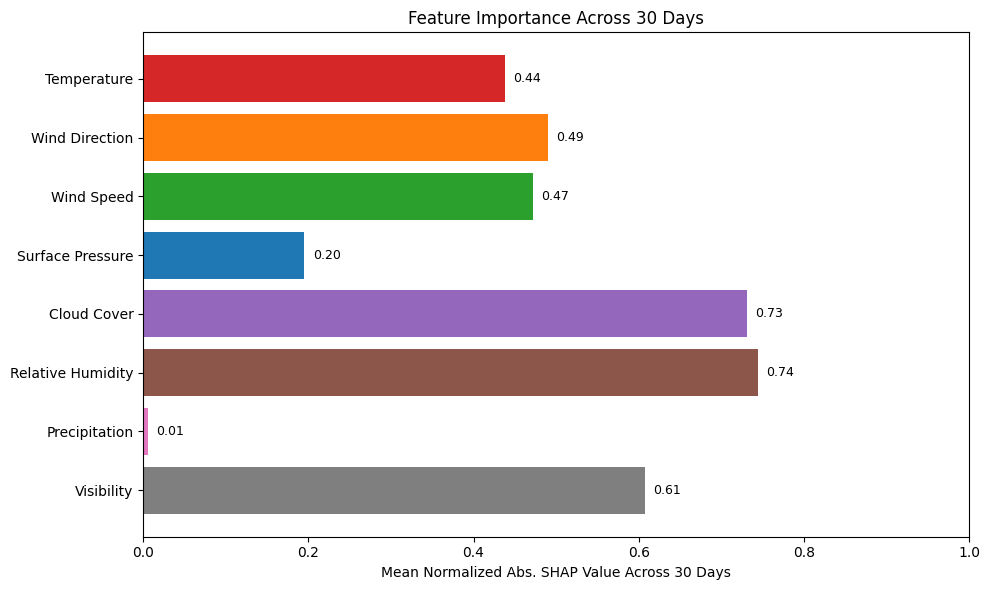

Saved normalized persistence influence plot to shap_plots/persistence_influence_normalized.png


In [30]:
# Aggregate normalized values across all days
persistence_importance = all_days_shap_finished.mean(axis=0)

vals = persistence_importance[features]
colors = [feature_colors[f] for f in features]

plt.figure(figsize=(10, 6))
bars = plt.barh([feature_labels[f] for f in features], vals, color=colors)

for bar, val in zip(bars, vals):
    plt.text(val + 0.01, bar.get_y() + bar.get_height()/2, f"{val:.2f}", va='center', fontsize=9)

plt.xlabel("Mean Normalized Abs. SHAP Value Across 30 Days")
plt.title("Feature Importance Across 30 Days")
plt.gca().invert_yaxis()
plt.xlim(0,1)
plt.tight_layout()

persistence_path = "shap_plots/persistence_influence_normalized.png"
plt.savefig(persistence_path, dpi=300)
plt.show()
print(f"Saved normalized persistence influence plot to {persistence_path}")